# LDA: Topic Modeling

With the enormous amount of data available today, it is important to have a systematic way of grouping them. For the case of text data, grouping can be performed based on the topics of the texts where texts with similar topics are catalogued together. Although reasonable, this approach has a serious practicle limitation: most of the data available today do not have a pre-tagged topic assigned to it. 

One way to overcome this and automatically assign topics to large volumes of unlabelled data is by unsupervised learning.

In this notebook, we will use Latent-Diritchlet-Allocation (LDA), an unsupervised learning algorithm, for clustering similar texts together. LDA assumes that each document is made of several topics and that each topic has a unique probability distribution of words associated with it (words which are common to one topic, say word "pizza" in topic "food", might not be common to some other topic, say "politics"). Given a new document, LDA can assign probabilities for the document to have been generated by each topic.

Will learn
   * pattern for processing large corpus of data
   * use iterators and generators
   * LDA

In [346]:
import tarfile
import itertools
import gensim
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

## 20News Dataset

In [191]:
alt_atheism_filepath_train    = './data/20news-bydate/20news-bydate-train/alt.atheism'
sport_baseball_filepath_train = './data/20news-bydate/20news-bydate-train/rec.sport.baseball'
sci_space_filepath_train      = './data/20news-bydate/20news-bydate-train/sci.space'

alt_atheism_filepath_test     = './data/20news-bydate/20news-bydate-test/alt.atheism'
sport_baseball_filepath_test  = './data/20news-bydate/20news-bydate-test/rec.sport.baseball'
sci_space_filepath_test       = './data/20news-bydate/20news-bydate-test/sci.space'

In [210]:
def process_message(message):
    
    """
    input: 
    A string message.
    
    output:
    A list of tokens(words) with the following processing done on wach token:
           1) The top and bottom blocks are removed 
           2) Lower the case of the doc
           3) Tokenize the doc
           4) Remove stopwords
           5) Stem the words
    """
    
    # skip email headers (first block) and footer (last block)
    blocks = message.split('\n\n')
    content = '\n\n'.join(blocks[1:-1])
    
    return [p_stemmer.stem(t_) for t_ in tokenize(content.lower()) if not t_ in STOPWORDS]

def iter_20NewsDocs(dir_path):
    for file_name in listdir(dir_path):
        if isfile(join(dir_path, file_name)):
            with open(join(dir_path, file_name), 'r') as f_:
                yield process_message(f_.read())

In [233]:
stream_alt_atheism_train    = iter_20NewsDocs(alt_atheism_filepath_train)
stream_sport_baseball_train = iter_20NewsDocs(sport_baseball_filepath_train)
stream_sci_space_train      = iter_20NewsDocs(sci_space_filepath_train)
stream_train                = itertools.chain(stream_alt_atheism_train, 
                                              stream_sport_baseball_train,
                                              stream_sci_space_train)

stream_alt_atheism_test     = iter_20NewsDocs(alt_atheism_filepath_test)
stream_sport_baseball_test  = iter_20NewsDocs(sport_baseball_filepath_test)
stream_sci_space_test       = iter_20NewsDocs(sci_space_filepath_test)
stream_test                 = itertools.chain(stream_alt_atheism_test,
                                              stream_sport_baseball_test,
                                              stream_sci_space_test)

In [234]:
id2word_20NewsDocs = gensim.corpora.dictionary.Dictionary(stream_train)

In [235]:
id2word_20NewsDocs.filter_extremes(no_below=10, no_above=0.1)

In [236]:
class NewsDocsCorpus(object):
    def __init__(self, dir_path_list, dictionary, num_docs=None):
        self.dir_path_list = dir_path_list
        self.dictionary = dictionary
        self.num_docs = num_docs
    def __iter__(self):
        for dir_path in self.dir_path_list:
            for tokens in itertools.islice(iter_20NewsDocs(dir_path), self.num_docs):
                yield self.dictionary.doc2bow(tokens)
    def __len__(self):
        return self.num_docs

In [241]:
dir_paths_train = [alt_atheism_filepath_train, sport_baseball_filepath_train, sci_space_filepath_train]
newsDocs_corpus_train = NewsDocsCorpus(dir_paths_train, id2word_20NewsDocs)

In [242]:
newsData_lda_model = gensim.models.LdaModel(newsDocs_corpus_train, num_topics=3, id2word=id2word_20NewsDocs, passes=10)

In [243]:
dir_paths_test = [alt_atheism_filepath_test, sport_baseball_filepath_test, sci_space_filepath_test]
newsDocs_corpus_test = NewsDocsCorpus(dir_paths_train, id2word_20NewsDocs)

In [329]:
def get_topic_probabilities(dir_path, num_docs=None):
    probability = []
    for c_ in itertools.islice(NewsDocsCorpus([dir_path], id2word_20NewsDocs, num_docs), num_docs):
        current_prob = [0, 0, 0]
        for topic, prob in newsData_lda_model.get_document_topics(c_):
            current_prob[topic] = prob  
        probability.append(current_prob)
        #probability.append(current_prob)
    return probability

In [332]:
alt_atheism_prob_test = get_topic_probabilities(alt_atheism_filepath_test)
sport_baseball_prob_test = get_topic_probabilities(sport_baseball_filepath_test)
sci_space_prob_test = get_topic_probabilities(sci_space_filepath_test)

In [347]:
def plot_probabilities(probabilities, col='red', topics=(0,1)):
    xy_list = [(doc_topic_prob[topics[0]], doc_topic_prob[topics[1]]) for doc_topic_prob in probabilities]
    plt.scatter(*zip(*xy_list), color=col)

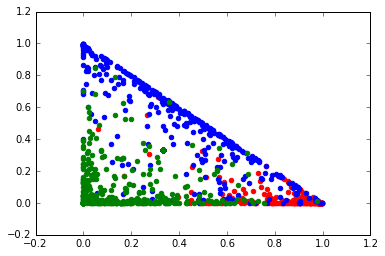

In [348]:
plot_probabilities(alt_atheism_prob_test, col='red')
plot_probabilities(sport_baseball_prob_test, col='blue')
plot_probabilities(sci_space_prob_test, col='green')
plt.show()